# Library Import

In [1]:
#to display all output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

#import scipy
import struct

from pathlib import Path
from sympy import divisors

from astropy.stats import jackknife_resampling
from astropy.stats import jackknife_stats

from scipy.stats import bootstrap

from scipy.optimize import curve_fit #for the fit

# Input Reading

## reading

In [3]:
#dirName = '../mesons-master/build/dat/'
#name = 'odd_prova26.odd_df2_4fop'
dirName = '../../data_from_scp/'
#name = 'tm_mesons_run3.mesons'
#name = 'tm_mesons_run8.mesons'
#name = 'tm_mesons_run9.mesons'
name = 'tm_mesons_run10.mesons'
datName = name + '.dat'

fileName = dirName + datName

In [4]:
plot_base_dir = 'plots/'
plot_dir = 'plot_'+name.split('.')[0]
Path(plot_base_dir+plot_dir).mkdir(parents=True, exist_ok=True)

In [5]:
verbose=True #True to print more output

step = 1 #steps at which configurations are read

early_stop = 0 #number of configurations (counting from the end) not read

In [6]:
#the correlators array will be stored in a dict having as keys the configurations
conf_dict = {}

#list with configurations number
conf_num_list = []

##### reading data from binary dat file #####
with open(fileName, mode='rb') as file: # b is important -> binary
    fileContent = file.read()

    #header is made up of 4 integers, 4x4=16byte
    header_size= 4*4

    #first 16 byte are four 4-byte integers
    ncorr, nnoise, tvals, noise_type = struct.unpack("iiii", fileContent[:header_size])

    #initialization of correlators' variables
    k1=['']*ncorr
    k2=['']*ncorr
    
    mu1=['']*ncorr
    mu2=['']*ncorr

    type1=['']*ncorr
    type2=['']*ncorr
    
    x0=['']*ncorr
    isreal=['']*ncorr

    
    #each correlator has an header of size given by 4x8 + 4x4 = 48byte
    corr_header_size = 4*8 + 4*4
    
    #then there are ncorr block, 8x8 + 4x4 (8 double and 4 int) with the following structure 
    for i in range(ncorr):
         k1[i], k2[i], mu1[i], mu2[i], type1[i], type2[i], x0[i], isreal[i] = struct.unpack("ddddiiii",fileContent[header_size+corr_header_size*i:header_size+corr_header_size*(i+1)])



    #initialization of correlators array
    corr = np.empty(shape=(ncorr,tvals,nnoise),dtype=complex) #correlators
    

    #configuration start right after the header
    first_conf = header_size+corr_header_size*ncorr
    
    #we compute the lenght of the data block for each configuration
    #          sizeof(int) (=confNumber)           ncorr * nnoise * tvals * 2 (re+im) * 8 (sizeof(double))
    conf_len = 4                                 +  nnoise * tvals * (2*ncorr - np.sum(isreal))         * 8         
    #the term with isreal is there because for real correlators only the real part gets stored

    #starting right after the header we read each configuration block
    for start_conf in range(first_conf, len(fileContent)-conf_len*early_stop, conf_len*step):
    #for start_conf in range(first_conf, len(fileContent)-conf_len, conf_len):

        #breaks loop if the file does not contain the whole correlator for the given configuration
        if start_conf+conf_len > len(fileContent) :
            break

        #reading of the configuration number
        conf_number = struct.unpack("i",fileContent[start_conf:start_conf+4])[0]
        if verbose==True:
            print(f"Reading: Gauge Conf = {conf_number}\n")

        #store of conf num
        if conf_number not in conf_num_list:
            conf_num_list.append(conf_number)

        #initialize to 0 the array storing the correlators
        corr.fill(complex(0,0))

        #initialize start reading
        start_reading = start_conf + 4

        #loop over the correlators (ncorr blocks of...)
        for ic in range(ncorr):
            
            #reading of 2 point functions
            for t in range(tvals):
                
                for inoise in range(nnoise):

                    if isreal[ic]==0:
                        #read re and im
                        re,im = struct.unpack("dd",fileContent[start_reading:start_reading+16])
                        #store them
                        corr[ic][t][inoise] = complex(re,im)
                        #update start reading
                        start_reading = start_reading+16

                    if isreal[ic]==1:
                        #read re
                        re = struct.unpack("d",fileContent[start_reading:start_reading+8])[0]
                        #store it
                        corr[ic][t][inoise] = complex(re,0.0)
                        #update start reading
                        start_reading = start_reading+8
                        
                    

        #store of correlators associated to the given configuration
        conf_dict[str(conf_number)] = corr.copy()

Reading: Gauge Conf = 1

Reading: Gauge Conf = 2

Reading: Gauge Conf = 3

Reading: Gauge Conf = 4

Reading: Gauge Conf = 5

Reading: Gauge Conf = 6

Reading: Gauge Conf = 7

Reading: Gauge Conf = 8

Reading: Gauge Conf = 9

Reading: Gauge Conf = 10

Reading: Gauge Conf = 11

Reading: Gauge Conf = 12

Reading: Gauge Conf = 13

Reading: Gauge Conf = 14

Reading: Gauge Conf = 15

Reading: Gauge Conf = 16

Reading: Gauge Conf = 17

Reading: Gauge Conf = 18

Reading: Gauge Conf = 19

Reading: Gauge Conf = 20

Reading: Gauge Conf = 21

Reading: Gauge Conf = 22

Reading: Gauge Conf = 23

Reading: Gauge Conf = 24

Reading: Gauge Conf = 25

Reading: Gauge Conf = 26

Reading: Gauge Conf = 27

Reading: Gauge Conf = 28

Reading: Gauge Conf = 29

Reading: Gauge Conf = 30

Reading: Gauge Conf = 31

Reading: Gauge Conf = 32

Reading: Gauge Conf = 33

Reading: Gauge Conf = 34

Reading: Gauge Conf = 35

Reading: Gauge Conf = 36

Reading: Gauge Conf = 37

Reading: Gauge Conf = 38

Reading: Gauge Conf =

In [7]:
#check on correct lenght calculations
(len(fileContent)-header_size-corr_header_size*ncorr)/conf_len

100.0

In [8]:
#construction of array with names and numbers of configurations
conf_names = list(conf_dict.keys())
conf_list = [int(conf) for conf in conf_names ]
nconf = len(conf_list)
nconf

100

In [9]:
#creation of a numpy array with all the correlators
correlators = np.empty(shape=(nconf,ncorr,tvals,nnoise),dtype=complex)
for iconf,nameconf in enumerate(conf_names):
    correlators[iconf] = conf_dict[nameconf]

In [10]:
if verbose:
    print("(nconf, ncorrelators, tvals, nnoise)")
    print(np.shape(correlators))

(nconf, ncorrelators, tvals, nnoise)
(100, 4, 32, 70)


In [11]:
if verbose:
    for icorr in range(ncorr):
        print(f"k1  = {k1[icorr]}\n")
        print(f"k2  = {k2[icorr]}\n")
        print(f"mu1 = {mu1[icorr]}\n")
        print(f"mu2 = {mu2[icorr]}\n")
        print(f"G1  = {type1[icorr]}\n")
        print(f"G2  = {type2[icorr]}\n")
        print(f"x0  = {x0[icorr]}\n")
        print(f"isr = {isreal[icorr]}\n\n")

k1  = 0.135217

k2  = 0.135217

mu1 = 0.0605

mu2 = 0.0605

G1  = 5

G2  = 5

x0  = 1

isr = 1


k1  = 0.135217

k2  = 0.135217

mu1 = 0.0605

mu2 = -0.0605

G1  = 5

G2  = 5

x0  = 30

isr = 0


k1  = 0.135217

k2  = 0.135217

mu1 = 0.0151

mu2 = -0.0151

G1  = 5

G2  = 5

x0  = 30

isr = 0


k1  = 0.135217

k2  = 0.135217

mu1 = 0.0151

mu2 = 0.0151

G1  = 5

G2  = 5

x0  = 1

isr = 1




## correlator identification

In [26]:
corr_x = correlators[:,0,:,:]
corr_z = correlators[:,1,:,:]
#corr_x = correlators[:,3,:,:]
#corr_z = correlators[:,2,:,:]

if verbose:
    print("(nconf, tvals, nnoise)")
    print(np.shape(corr_x))
    print(np.shape(corr_z))

(nconf, tvals, nnoise)
(100, 32, 70)
(100, 32, 70)


## average over noise

In [27]:
corr_x_navg = corr_x.mean(axis=-1)
corr_z_navg = corr_z.mean(axis=-1)

if verbose:
    print("(nconf, tvals)")
    print(np.shape(corr_x_navg))
    print(np.shape(corr_z_navg))

(nconf, ncorrelators, tvals)
(100, 32)
(100, 32)


In [28]:
#check that the imaginary part of the z correlator is noise
corr_z_navg[0]
corr_z_navg.mean(axis=0)
(corr_z_navg.mean(axis=0).imag/corr_z_navg.mean(axis=0).real)[1:-1]

array([0.00000000e+00+0.00000000e+00j, 3.23111732e-03-1.26676594e-03j,
       4.92268388e-03-2.10289768e-03j, 6.11138202e-03-2.51409652e-03j,
       7.52370625e-03-2.69375104e-03j, 9.67313767e-03-1.45627049e-03j,
       1.34403905e-02-9.02986156e-05j, 1.82015327e-02+3.10062502e-03j,
       2.33708595e-02+8.53169066e-03j, 2.87141759e-02+1.76108728e-02j,
       3.01999182e-02+2.53472764e-02j, 3.40468134e-02+3.43078986e-02j,
       3.15596582e-02+3.17922667e-02j, 1.98404670e-02+1.61464661e-02j,
       7.72257332e-03-1.96650441e-02j, 7.67739932e-03-7.06335362e-02j,
       4.25428883e-02-1.23700662e-01j, 1.24734204e-01-1.55089390e-01j,
       2.25645349e-01-2.88742782e-01j, 1.73625536e-01-7.15317257e-01j,
       3.24309666e-01-9.56866387e-01j, 9.01128758e-01-6.69657506e-01j,
       2.05795871e+00+4.90470341e-02j, 4.36297660e+00+1.23054725e+00j,
       9.16936977e+00+3.20361085e+00j, 1.77690057e+01+5.67726280e+00j,
       3.52434530e+01+8.15912481e+00j, 7.49107419e+01+7.53908085e+00j,
      

array([0.00000000e+00+0.00000000e+00j, 2.89756114e-03-2.54497266e-04j,
       4.71553399e-03-4.59234755e-04j, 5.90327616e-03-6.91338216e-04j,
       7.00111328e-03-1.10881745e-03j, 8.14641365e-03-1.54584003e-03j,
       9.46194578e-03-1.88919354e-03j, 1.09504713e-02-2.08191435e-03j,
       1.28872112e-02-2.15253774e-03j, 1.53227296e-02-2.49716888e-03j,
       1.83352704e-02-3.35146885e-03j, 2.27254476e-02-3.87296513e-03j,
       2.87203150e-02-4.23773560e-03j, 3.72556392e-02-4.11295151e-03j,
       5.14979830e-02-4.88407102e-03j, 7.83475551e-02-9.36685222e-03j,
       1.24413815e-01-1.59528039e-02j, 1.98381281e-01-2.21713106e-02j,
       3.22906997e-01-2.37412521e-02j, 5.47952590e-01-3.93819185e-02j,
       9.52934762e-01-3.85674115e-02j, 1.67443606e+00-1.92131041e-02j,
       2.94244379e+00-3.99409038e-06j, 5.24332355e+00+2.02765601e-02j,
       9.53210240e+00-1.72699983e-03j, 1.78884188e+01-1.83318128e-02j,
       3.52276950e+01-8.62540115e-02j, 7.67260649e+01-1.82623004e-01j,
      

/tmp/ipykernel_43149/2966480037.py:4: RuntimeWarning: invalid value encountered in divide
  (corr_z_navg.mean(axis=0).imag/corr_z_navg.mean(axis=0).real)[1:-1]


array([-8.78315431e-02, -9.73876461e-02, -1.17110939e-01, -1.58377304e-01,
       -1.89757125e-01, -1.99662267e-01, -1.90120981e-01, -1.67028979e-01,
       -1.62971543e-01, -1.82788079e-01, -1.70424152e-01, -1.47551850e-01,
       -1.10398093e-01, -9.48400449e-02, -1.19555131e-01, -1.28223734e-01,
       -1.11761102e-01, -7.35234986e-02, -7.18710326e-02, -4.04722474e-02,
       -1.14743731e-02, -1.35740584e-06,  3.86711975e-03, -1.81177222e-04,
       -1.02478665e-03, -2.44847162e-03, -2.38019511e-03, -2.02771409e-03,
       -5.04167504e-04, -1.27348538e-05])

## preliminary plots

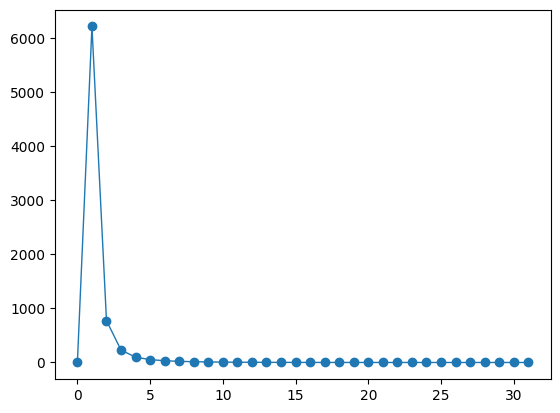

In [29]:
times = np.arange(tvals)

plt.plot(times,np.mean(corr_x_navg,axis=0).real, '-o',linewidth = 1)

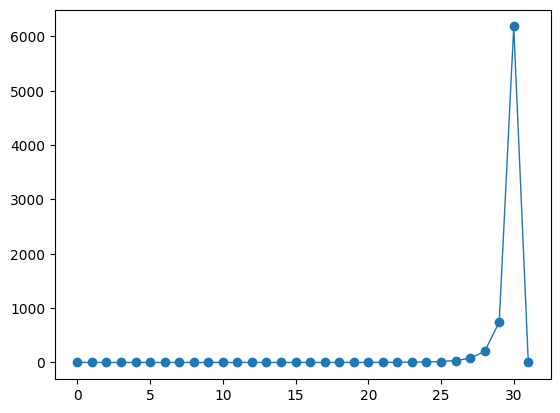

In [30]:
times = np.arange(tvals)

plt.plot(times,np.mean(corr_z_navg.real,axis=0).real, '-o',linewidth = 1)

# Jackknife analysis

## noise average

In [31]:
#it is already done above
if verbose:
    print("(nconf,tvals)")
    print(np.shape(corr_x_navg))
    print(np.shape(corr_z_navg))

(nconf,tvals)
(100, 32)
(100, 32)


## creation of jackknife replicates

In [32]:
delta = 1 #binning of the jackknife procedure (we delete delta conf for each replicate

corr_x_navg_resamp = np.asarray( [np.delete(corr_x_navg, list(range(iconf,min(iconf+delta,nconf))) ,axis=0) for iconf in range(0,nconf,delta)] )
corr_z_navg_resamp = np.asarray( [np.delete(corr_z_navg, list(range(iconf,min(iconf+delta,nconf))) ,axis=0) for iconf in range(0,nconf,delta)] )

nresamples = int(nconf/delta)


if verbose:
    print("(nresamples,nconf-delta,tvals)")
    print(np.shape(corr_x_navg_resamp))
    print(np.shape(corr_z_navg_resamp))

(nresamples,nconf-delta,tvals)
(100, 99, 32)
(100, 99, 32)


## Mass formula

In [33]:
def mass(corr_ratio,t,verb=False):

    #it = 0
    max_it = 150
    eps=10^-5

    Time = tvals-1

    m0 = np.log(corr_ratio)

    massa = m0 #at iteration 0 the sinh is an exp and the mass is simply the log of the ration of correlators

    if corr_ratio <1.0:
        massa = 0
        return massa

    for it in range(max_it):


        '''
        if tvals-2*(t-1) -2 == 0 or tvals-2*(t-1) +2 ==0:
           break
        '''        
        

        #computes new mass from previous one
        
        #new_m = np.log(corr_ratio * (1-np.exp(-2*old_m*(tvals-t-1)))/(1-np.exp(-2*old_m*(tvals-t)) ) )
        

        '''
        if t <= tvals/2:
            den = 1 - np.exp( -massa * ( tvals-2*(t-1)     ) )
            num = 1 - np.exp( -massa * ( tvals-2*(t-1) -2  ) )
                 )
        else:
            den = 1 - np.exp( massa * ( tvals-2*(t-1)     ) )
            num = 1 - np.exp( massa * ( tvals-2*(t-1) +2  ) )
        '''

        den = 1 - np.exp( -2*massa * ( Time-t  ) )
        num = 1 - np.exp( -2*massa * ( Time-t-1) )
        

        new_massa = np.log( corr_ratio * num/den )

        if it%30 == 0 and verb==True:
            print(f"x t{t} it{it} delta = {np.abs((new_massa-massa)/massa)} \n")
        
        #if np.abs((new_m-old_m)/old_m)<eps:
            #break

        '''
        if np.abs(new_massa)>4.0 or new_massa<0:
            massa = 10
            break
        '''

        '''
        if np.abs(massa-new_massa) < 3e-7:
            massa=new_massa
            break
        '''

        massa = new_massa

    return massa

In [34]:
def mass_z(corr_ratio,t,verb=False):

    #it = 0
    max_it = 150
    eps=10^-5

    #Time = tvals-1

    m0 = - np.log(corr_ratio)

    massa = m0 #at iteration 0 the sinh is an exp and the mass is simply the log of the ration of correlators

    if corr_ratio >1.0:
        massa = 0
        return massa

    for it in range(max_it):


        #if tvals-2*(t-1) -2 == 0 or tvals-2*(t-1) +2 ==0:
         #   break
        
        

        #computes new mass from previous one
        
        #new_m = np.log(corr_ratio * (1-np.exp(-2*old_m*(tvals-t-1)))/(1-np.exp(-2*old_m*(tvals-t)) ) )
        

        '''
        if t <= tvals/2:
            den = 1 - np.exp( -massa * ( tvals-2*(t-1)     ) )
            num = 1 - np.exp( -massa * ( tvals-2*(t-1) -2  ) )
                 )
        else:
            den = 1 - np.exp( massa * ( tvals-2*(t-1)     ) )
            num = 1 - np.exp( massa * ( tvals-2*(t-1) +2  ) )
        '''

        den = 1 - np.exp( -2*massa *   t   )
        num = 1 - np.exp( -2*massa * (t+1) )
        

        new_massa = - np.log( corr_ratio * num/den )

        if it%30 == 0 and verb==True:
            print(f"z t{t} it{it} delta = {np.abs((new_massa-massa)/massa)} \n")
        
        #if np.abs((new_m-old_m)/old_m)<eps:
            #break

        '''
        if np.abs(new_massa)>4.0 or new_massa<0:
            massa = 10
            break
        '''

        '''
        if np.abs(massa-new_massa) < 3e-7:
            massa=new_massa
            break
        '''

        massa = new_massa

    return massa

## mass jackknife estimation

In [35]:
#first we take the correlator averaged over the gauge configurations (for each subsample)
corr_x_navg_resamp_gavg = corr_x_navg_resamp.mean(axis=1)
corr_z_navg_resamp_gavg = corr_z_navg_resamp.mean(axis=1)

#this is the array with the replicates !!!
mass_x_array = np.empty(shape=(nresamples,tvals-1),dtype=float)
mass_z_array = np.empty(shape=(nresamples,tvals-1),dtype=float)

#then we estimate the mass
for ires in range(nresamples):
    for t in range(tvals-1):
        #insert here the formula for the mass:
        #mass_x_array[ires,t] = np.log(corr_x_navg_resamp_gavg[ires,t].real /  corr_x_navg_resamp_gavg[ires,t+1].real )
        mass_x_array[ires,t] = mass( corr_x_navg_resamp_gavg[ires,t].real /  corr_x_navg_resamp_gavg[ires,t+1].real , t)
        mass_z_array[ires,t] = mass_z( corr_z_navg_resamp_gavg[ires,t].real /  corr_z_navg_resamp_gavg[ires,t+1].real , t)
        #mass_z_array[ires,tvals-2-t] = mass( corr_z_navg_resamp_gavg[ires,tvals-1-t].real /  corr_z_navg_resamp_gavg[ires,tvals-1-(t+1)].real , t)


#we then estimate the mass also on the whole dataset
corr_x_navg_gavg = corr_x_navg.mean(axis=0)
corr_z_navg_gavg = corr_z_navg.mean(axis=0)

#this is the array with the mass computed on the whole dataset !!!
mass_x_array_jacktotal = np.empty(shape=(tvals-1),dtype=float)
mass_z_array_jacktotal = np.empty(shape=(tvals-1),dtype=float)

for t in range(tvals-1):
    #mass_x_array_jacktotal[t] = np.log( corr_x_navg_gavg[t].real / corr_x_navg_gavg[t+1].real )
    mass_x_array_jacktotal[t] = mass( corr_x_navg_gavg[t].real / corr_x_navg_gavg[t+1].real , t, verb=True)
    mass_z_array_jacktotal[t] = mass_z( corr_z_navg_gavg[t].real / corr_z_navg_gavg[t+1].real , t, verb=True)
    #mass_z_array_jacktotal[tvals-2-t] = mass( corr_z_navg_gavg[tvals-1-t].real / corr_z_navg_gavg[tvals-1-(t+1)].real , t, verb=True)




if verbose:
    print("(nresamples,tvals)")
    print(np.shape(corr_x_navg_resamp_gavg))
    print(np.shape(corr_z_navg_resamp_gavg))

    print("(tvals)")
    print(np.shape(corr_x_navg_gavg))
    print(np.shape(corr_z_navg_gavg))

/tmp/ipykernel_43149/4198091428.py:9: RuntimeWarning: divide by zero encountered in log
  m0 = np.log(corr_ratio)
/tmp/ipykernel_43149/3543371108.py:40: RuntimeWarning: invalid value encountered in scalar multiply
  den = 1 - np.exp( -2*massa *   t   )
/tmp/ipykernel_43149/3543371108.py:41: RuntimeWarning: overflow encountered in exp
  num = 1 - np.exp( -2*massa * (t+1) )
/tmp/ipykernel_43149/3543371108.py:44: RuntimeWarning: invalid value encountered in scalar divide
  new_massa = - np.log( corr_ratio * num/den )
/tmp/ipykernel_43149/3543371108.py:40: RuntimeWarning: overflow encountered in exp
  den = 1 - np.exp( -2*massa *   t   )
/tmp/ipykernel_43149/4198091428.py:45: RuntimeWarning: divide by zero encountered in log
  new_massa = np.log( corr_ratio * num/den )
/tmp/ipykernel_43149/4198091428.py:45: RuntimeWarning: invalid value encountered in scalar divide
  new_massa = np.log( corr_ratio * num/den )
/tmp/ipykernel_43149/2871574162.py:14: RuntimeWarning: divide by zero encountered

z t0 it0 delta = nan 

z t0 it30 delta = nan 

z t0 it60 delta = nan 

z t0 it90 delta = nan 

z t0 it120 delta = nan 

x t1 it0 delta = 0.0 

x t1 it30 delta = 0.0 

x t1 it60 delta = 0.0 

x t1 it90 delta = 0.0 

x t1 it120 delta = 0.0 

z t1 it0 delta = 0.6577610016422589 

z t1 it30 delta = nan 

z t1 it60 delta = nan 

z t1 it90 delta = nan 

z t1 it120 delta = nan 

x t2 it0 delta = 0.0 

x t2 it30 delta = 0.0 

x t2 it60 delta = 0.0 

x t2 it90 delta = 0.0 

x t2 it120 delta = 0.0 

z t2 it0 delta = 0.988152495844955 

z t2 it30 delta = nan 

z t2 it60 delta = nan 

z t2 it90 delta = nan 

z t2 it120 delta = nan 

x t3 it0 delta = 0.0 

x t3 it30 delta = 0.0 

x t3 it60 delta = 0.0 

x t3 it90 delta = 0.0 

x t3 it120 delta = 0.0 

z t3 it0 delta = 0.8810042891690381 

z t3 it30 delta = nan 

z t3 it60 delta = nan 

z t3 it90 delta = nan 

z t3 it120 delta = nan 

x t4 it0 delta = 1.2019623721692044e-14 

x t4 it30 delta = 0.0 

x t4 it60 delta = 0.0 

x t4 it90 delta = 0.0 

x 

/tmp/ipykernel_43149/2871574162.py:29: RuntimeWarning: divide by zero encountered in scalar divide
  mass_x_array_jacktotal[t] = mass( corr_x_navg_gavg[t].real / corr_x_navg_gavg[t+1].real , t, verb=True)
/tmp/ipykernel_43149/2871574162.py:30: RuntimeWarning: divide by zero encountered in scalar divide
  mass_z_array_jacktotal[t] = mass_z( corr_z_navg_gavg[t].real / corr_z_navg_gavg[t+1].real , t, verb=True)


In [36]:
#the estimate is the mean of the replicates
estimate = np.mean(mass_x_array,axis=0)
estimate_z = np.mean(mass_z_array,axis=0)

#the bias is the following difference between the mean of the replicates and the mean on the whole dataset
bias = (nresamples-1) * (estimate-mass_x_array_jacktotal)
bias_z = (nresamples-1) * (estimate_z-mass_z_array_jacktotal)


#wrong formula for std ???
#std = np.std(matele_array,axis=0) * np.sqrt(nresamples-1) #/ np.sqrt(nresamples) 

#the std is given by the following formula (variance of replicates times n-1)
std = np.sqrt( (nresamples-1)/nresamples * np.sum( (mass_x_array - estimate)**2,axis=0 ) )
std_z = np.sqrt( (nresamples-1)/nresamples * np.sum( (mass_z_array - estimate_z)**2,axis=0 ) )

#then we correct the estimate for the bias
estimate_biascorr = estimate-bias
estimate_biascorr_z = estimate_z-bias_z

if verbose:
    print("(tvals)")
    print(np.shape(estimate_biascorr))
    print(np.shape(std))
    print(np.shape(estimate_biascorr_z))
    print(np.shape(std_z))

(tvals)
(31,)
(31,)
(31,)
(31,)


## plots

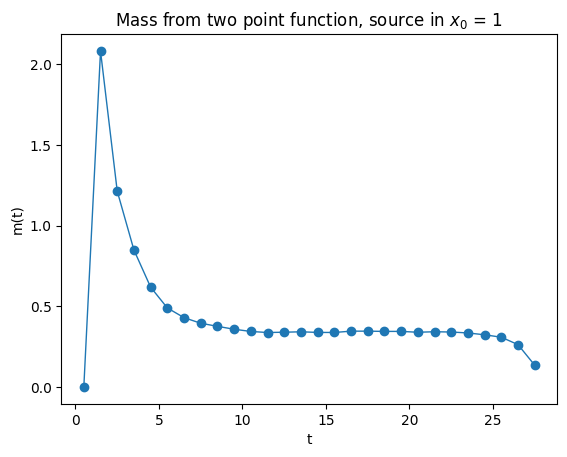

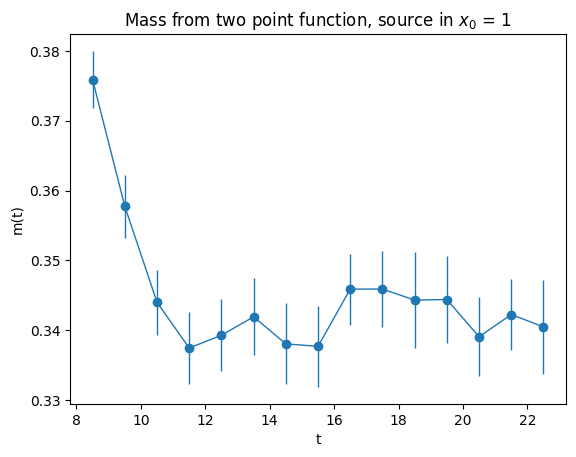

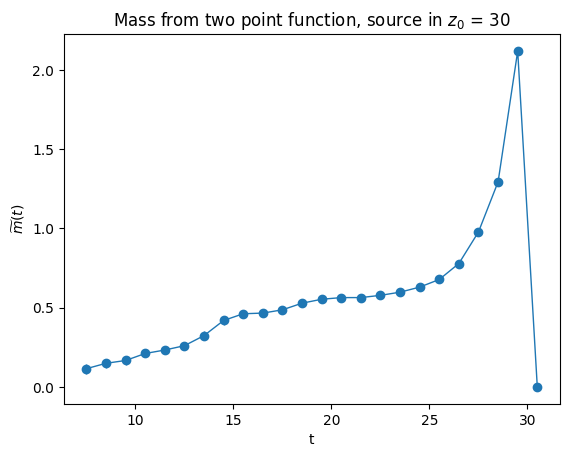

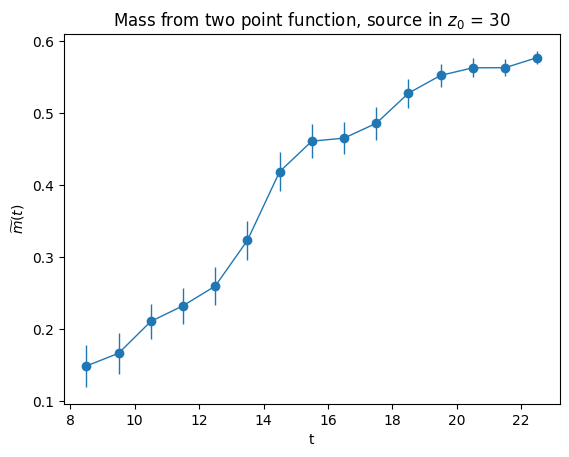

In [37]:
times = np.arange(0,tvals)
eff_mass_times = times[:-1]+0.5

cut=8

_=plt.errorbar(eff_mass_times[:],estimate_biascorr[:],std[:],marker='o',linewidth=1)
_=plt.title(r"Mass from two point function, source in $x_0$ = 1")
_=plt.xlabel("t")
_=plt.ylabel(r"m(t)")
plt.savefig("mass_x.png")

_=plt.figure()
_=plt.errorbar(eff_mass_times[cut:-cut],estimate_biascorr[cut:-cut],std[cut:-cut],marker='o',linewidth=1)
_=plt.title(r"Mass from two point function, source in $x_0$ = 1")
_=plt.xlabel("t")
_=plt.ylabel(r"m(t)")
plt.savefig("mass_x_zoom.png")


_=plt.figure()
_=plt.errorbar(eff_mass_times[:],estimate_biascorr_z[:],std_z[:],marker='o',linewidth=1)
_=plt.title(r"Mass from two point function, source in $z_0$ = 30")
_=plt.xlabel("t")
_=plt.ylabel(r"$\widetilde{m}(t)$")
plt.savefig("mass_z.png")


_=plt.figure()
_=plt.errorbar(eff_mass_times[cut:-cut],estimate_biascorr_z[cut:-cut],std_z[cut:-cut],marker='o',linewidth=1)
_=plt.title(r"Mass from two point function, source in $z_0$ = 30")
_=plt.xlabel("t")
_=plt.ylabel(r"$\widetilde{m}(t)$")
plt.savefig("mass_z_zoom.png")

In [38]:
estimate_biascorr
estimate_biascorr_z

array([0.        , 2.08314782, 1.21433569, 0.84934085, 0.61884557,
       0.48991656, 0.42959513, 0.39505013, 0.37587569, 0.35776461,
       0.34403058, 0.33747572, 0.3393002 , 0.34194645, 0.33807351,
       0.33771418, 0.34590239, 0.34591581, 0.34433323, 0.34441849,
       0.33908876, 0.34227108, 0.3405013 , 0.33475377, 0.32339662,
       0.30827245, 0.26218839, 0.1345167 ,        nan,        nan,
              nan])

array([       nan,        nan,        nan,        nan,        nan,
              nan,        nan, 0.11502649, 0.14906278, 0.16671119,
       0.2109594 , 0.2327247 , 0.26003791, 0.3236274 , 0.41906642,
       0.46144442, 0.46564275, 0.48628229, 0.5281103 , 0.55286719,
       0.56334266, 0.56351991, 0.57758168, 0.59761862, 0.62944511,
       0.67765325, 0.77839593, 0.97758764, 1.29324361, 2.11823376,
       0.        ])

In [39]:
np.mean(estimate_biascorr[cut:-cut])
np.mean(estimate_biascorr_z[cut:-cut])

0.34497413271103455

0.397398733684443

# Formulae

\begin{equation}
\begin{split}
ratio = \frac{C[t]}{c[t+1]} = &\frac{e^{m(T-t)}-e^{-m(T-t)}}{e^{m(T-t-1)}-e^{-m(T-t-1)}}\\
& = \frac{e^{m(T-t)}-e^{-m(T-t)}}{e^{-m}\left(e^{m(T-t)}-e^{-m(T-t-2)}\right)}\\
&= e^{m} \frac{e^{m(T-t)}-e^{-m(T-t)}}{e^{m(T-t)}-e^{-m(T-t-2)}}\\
&= e^{m} \frac{1-e^{-2m(T-t)}}{1-e^{-2m(T-t-1)}}
\end{split}              
\end{equation}

\begin{equation}
\Rightarrow e^m = \frac{C[t]}{c[t+1]} \frac{1-e^{-2m(T-t-1)}}{1-e^{-2m(T-t)}}  
\end{equation}

# Direct Fit

In [60]:
def chi2(result,data,data_std):
    return np.sum( ((result-data)/data_std)**2 )

In [68]:
guess_mass_x = 0.4873
guess_amp_x =  corr_x_navg_gavg[int(tvals/2)].real * np.exp(-tvals/2 *guess_mass_x)

def fit_sinh_x(t,amp,mass):
    return amp*np.sinh(mass*(tvals-1-t)) #tvals-1 because T=tvals-1


guess_mass_z = 0.4873
guess_amp_z =  corr_z_navg_gavg[int(tvals/2)].real * np.exp(-tvals/2 * guess_mass_z)

def fit_sinh_z(t,amp,mass):
    return amp*np.sinh(mass*t)

In [69]:
cut = 8

fit_times_x = times[cut:-cut]
fit_times_z = times[cut:-cut]

fit_data_x = corr_x_navg_gavg[cut:-cut].real
fit_data_z = corr_z_navg_gavg[cut:-cut].real

guess_x = [guess_amp_x,guess_mass_x]
guess_z = [guess_amp_z,guess_mass_z]

In [70]:
guess_x

[0.00036502959469813075, 0.4873]

In [71]:
popt_x,pcov_x = curve_fit(fit_sinh_x, fit_times_x, fit_data_x, p0=guess_x)
perr_x = np.sqrt(np.diag(pcov_x))
fit_result_x = fit_sinh_x(fit_times_x,*popt_x)

popt_z,pcov_z = curve_fit(fit_sinh_z, fit_times_z, fit_data_z, p0=guess_z)
perr_z = np.sqrt(np.diag(pcov_z))
fit_result_z = fit_sinh_z(fit_times_z,*popt_z)

In [72]:
print("Result x:")
print(f"amp:  {popt_x[0]} +- {perr_x[0]}")
print(f"mass: {popt_x[1]} +- {perr_x[1]}\n")

print("Result z:")
print(f"amp:  {popt_z[0]} +- {perr_z[0]}")
print(f"mass: {popt_z[1]} +- {perr_z[1]}\n")

Result x:
amp:  0.008166788574486087 +- 0.0004591506878516389
mass: 0.3541733106774977 +- 0.002547074267696512

Result z:
amp:  2.2709922257249077e-05 +- 1.7838634991535252e-06
mass: 0.566967897216524 +- 0.0034847412332784287



chi2: 1.294877269049966


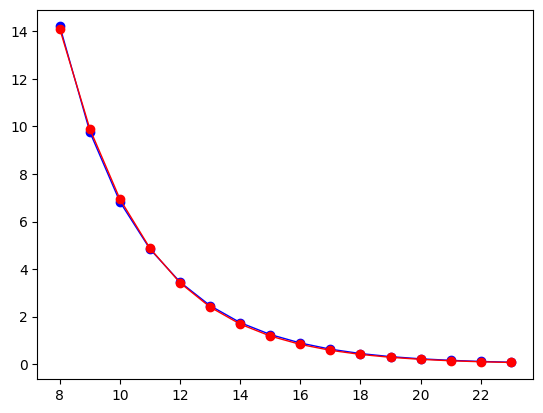

In [73]:
plt.plot(fit_times_x,fit_data_x,'-o',label='data',color='blue',linewidth=1)
plt.plot(fit_times_x,fit_result_x,'-o',label='fit',color='red',linewidth=1)

print(f"chi2: {chi2(fit_result_x,fit_data_x,corr_x_navg.std(axis=0)[cut:-cut])}")

chi2: 1.6909035878881489


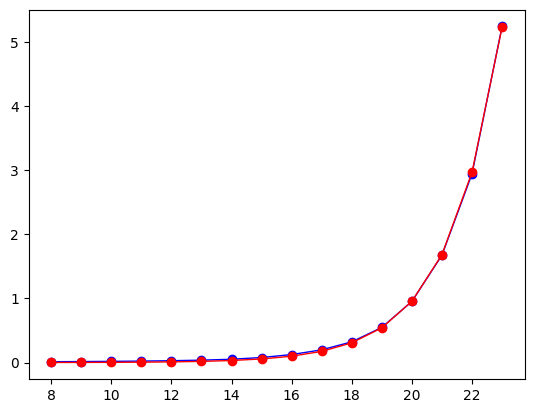

In [74]:
plt.plot(fit_times_z,fit_data_z,'-o',label='data',color='blue',linewidth=1)
plt.plot(fit_times_z,fit_result_z,'-o',label='fit',color='red',linewidth=1)

print(f"chi2: {chi2(fit_result_z,fit_data_z,corr_z_navg.std(axis=0)[cut:-cut])}")

## FARE UN FIT DEL GENERE PER OGNI REPLICA JACKNIFE